In [1]:
import gym
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
from itertools import count
import random
import math
from IPython import display
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.autograd import Variable

In [9]:
env = gym.make('Breakout-ram-v0')
observation = env.reset()
print(observation/255)

[2017-03-09 20:28:43,901] Making new env: Breakout-ram-v0


[ 0.24705882  0.24705882  0.24705882  0.24705882  0.24705882  0.24705882
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          0.75294118  0.75294118  0.75294118
  0.75294118  0.75294118  0.75294118  1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          0.94117647  0.          0.          1.          0.
  0.          0.94117647  0.          0.01960784  0.          0.
  0.02352941  0.          0.2745098   0.71372549  0.5254902   0.77647059
  0.08627451  0.14901961  0.21176471  0.2745098   0.34509804  0.02352941
  0.57254902  0.          0.03137255  0.          0.          0.          0.
  0.          0.          0.94509804  0.          0.94901961  0.
  0.94901961  0.09803922  0.94509804  0

In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None) 
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.l1 = nn.Linear(128, 1024)
        self.l2 = nn.Linear(1024, 256)
        self.l3 = nn.Linear(256, 64)
        self.l4 = nn.Linear(64, 6)
    
    def forward(self, x):
        y = F.tanh(self.l1(x))
        y = F.tanh(self.l2(y))
        y = F.tanh(self.l3(y))
        return self.l4(y)

class big_ram(nn.Module):
    def __init__(self):
        super(big_ram, self).__init__()
        self.l1 = nn.Linear(128, 128)
        self.l2 = nn.Linear(128, 128)
        self.l3 = nn.Linear(128, 128)
        self.l4 = nn.Linear(128, 128)
        self.l5 = nn.Linear(128, 6)
    
    def forward(self, x):
        y = F.relu(self.l1(x))
        y = F.relu(self.l2(y))
        y = F.relu(self.l3(y))
        y = F.relu(self.l4(y))
        return self.l5(y)

In [5]:
BATCH_SIZE = 64
GAMMA = 0.999
EPS_START = 0.5
EPS_END = 0.05
EPS_DECAY = 200
USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
print(dtype)

<class 'torch.cuda.FloatTensor'>


In [6]:
model = big_ram()
memory = ReplayMemory(10000)
optimizer = optim.Adam(model.parameters())

model.type(dtype)

big_ram (
  (l1): Linear (128 -> 128)
  (l2): Linear (128 -> 128)
  (l3): Linear (128 -> 128)
  (l4): Linear (128 -> 128)
  (l5): Linear (128 -> 6)
)

In [10]:
steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
#     eps_threshold = 1
    steps_done += 1
    if sample > eps_threshold:
        return model(Variable(state.view(1, len(state)).clone().type(dtype), volatile=True)).data.max(1)[1].cpu()
    else:
        return torch.LongTensor([[env.action_space.sample()]])

def plot_scores():
    plt.figure(1)
    plt.clf()
    scores_t = torch.Tensor(episode_scores)
    plt.plot(scores_t.numpy())
    # Take 100 episode averages and plot them too
    if len(scores_t) >= 100:
        means = scores_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions)) 

    non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))
    non_final_next_states_t = torch.stack(tuple(s for s in batch.next_state if s is not None)).type(dtype)
    non_final_next_states = Variable(non_final_next_states_t, volatile=True)
    state_batch = Variable(torch.stack(batch.state))
    action_batch = Variable(torch.stack(batch.action).squeeze(2))
    reward_batch = Variable(torch.stack(batch.reward))

    if USE_CUDA:
        state_batch = state_batch.cuda()
        action_batch = action_batch.cuda()
    state_action_values = model(state_batch).gather(1, action_batch).cpu()

    next_state_values = Variable(torch.zeros(BATCH_SIZE))
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0].cpu()
    next_state_values.volatile = False
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
    
    optimizer.zero_grad()
    loss.backward()

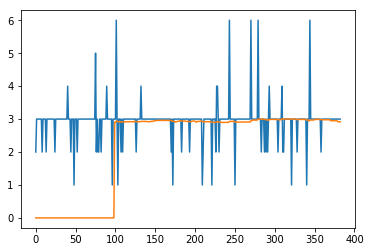

KeyboardInterrupt: 

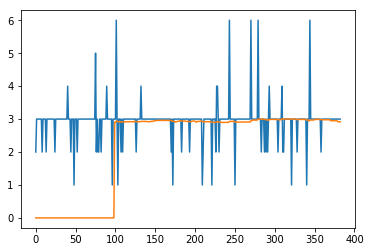

In [16]:
episode_scores = []
for i_episode in count(1):

    state = torch.from_numpy(env.reset()).float()/255 # normalize s.t. memory is bound between 0 and 1
    total_reward = 0
    
    for t in count():
        action = select_action(state)
        next_state, reward, done, _ = env.step(action[0,0])
        reward = torch.Tensor([reward])
        next_state = torch.from_numpy(next_state).float()/255 # more normalization 
        
        memory.push(state, action, next_state, reward)
        
        # Move to the next state
        state = next_state
        
        # Perform one step of the optimization (on the target network)
        optimize_model()
        
        total_reward += reward
        if done:
            episode_scores.append(total_reward[0])
            plot_scores()
            break